In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

#This line will hide code by default when the notebook is exported as HTML
#di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

display(HTML("<style>.container { width:100% !important; }</style>"))
import os

In [2]:
import hail as hl

localfs_path = os.environ.get('SCRATCH_LOCAL') + '/'
hl.init(tmp_dir=localfs_path, local_tmpdir=localfs_path, 
        spark_conf={'spark.driver.memory': '15G', 'spark.executor.memory': '30G'})

2022-08-18 21:49:36 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-08-18 21:49:37 WARN  Hail:43 - This Hail JAR was compiled for Spark 3.1.3, running with Spark 3.1.2.
  Compatibility is not guaranteed.


Running on Apache Spark version 3.1.2
SparkUI available at http://p1385.prometheus:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.97-937922d7f46c
LOGGING: writing to /net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/analysis/hail-20220818-2149-0.2.97-937922d7f46c.log


In [3]:
from hail.plot import show
from pprint import pprint
from bokeh.layouts import gridplot
hl.plot.output_notebook()


import numpy as np
import pandas as pd
from functools import reduce
from itertools import chain

from bokeh.plotting import output_notebook, show, figure
from bokeh.palettes import viridis
from scipy import stats
import seaborn as sns

output_notebook()


Loading BokehJS ...

Loading BokehJS ...

### The matrix table below has already been filtered and annotated, see preprocessing/joint-with-gts/genotype-and-filter.ipynb

In [ ]:
mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/full_healthy.mt')

In [ ]:
mt.count()

In [1]:
proper_controls = ['WGS_37b', 'WGS_37c', 'WGS_163d', 'WGS_7120', 'WGS_7142', 'WGS_7143', 'WGS_7152',
 'WGS_7153', 'WGS_85b', 'WGS_147c', 'WGS_180b', 'WGS_185c', 'WGS_6819', 'S_7213', 'S_7227', 'S_7241', 'S_7246', 'S_7254', 'S_7274',
                   'S_7307', '494', '462', '468', '492', '490'] 

In [2]:
len(proper_controls)

25

## only keep intragenic variants

In [ ]:
mt = mt.filter_rows(mt.within_gene == hl.empty_array(hl.tstr), keep = False)
mt.write(localfs_path+'intragenic.mt')

## load gene lists

In [ ]:
mt = hl.read_matrix_table(localfs_path+'intragenic.mt')

In [ ]:
mt.count()

In [4]:
gene_lists_sport = hl.import_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/external-data/gene-lists/sportsmen_gene_lists_october_2021.csv', quote="\"")
gene_lists_gts = hl.import_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/external-data/burden-and-family/gene-lists-burden-and-family.csv', delimiter = ';', quote="\"")
gene_lists_genebass = hl.import_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/external-data/gene-lists/genebass_lists.csv', delimiter = '\t', quote="\"")

2022-02-08 18:31:39 Hail: INFO: Reading table without type imputation
  Loading field 'brain' as type str (not specified)
  Loading field 'sekletal_muscle' as type str (not specified)
  Loading field 'heart' as type str (not specified)
  Loading field 'Hp_0011804' as type str (not specified)
  Loading field 'Hp_0011805' as type str (not specified)
  Loading field 'endurance_markers_2021' as type str (not specified)
  Loading field 'power_markers_2021' as type str (not specified)
  Loading field 'strength_markers_2021' as type str (not specified)
  Loading field 'soft_tissue_injury_2021' as type str (not specified)
2022-02-08 18:31:39 Hail: INFO: Reading table without type imputation
  Loading field 'Cerebral_Cortex' as type str (not specified)
  Loading field 'Basal_Ganglia' as type str (not specified)
  Loading field 'Hypothalmus' as type str (not specified)
  Loading field 'Thalmus' as type str (not specified)
  Loading field 'Midbrain' as type str (not specified)
  Loading field 'Do

In [5]:
gene_lists_sport = gene_lists_sport.to_pandas()
gene_lists_gts = gene_lists_gts.to_pandas()
gene_list_genebass = gene_lists_genebass.to_pandas()

In [6]:
gene_lists = ['brain', 'sekletal_muscle', 'heart', 'Hp_0011804', 'Hp_0011805',
       'endurance_markers_2021', 'power_markers_2021', 'strength_markers_2021',
       'soft_tissue_injury_2021', #sport
        'Cerebral_Cortex', 'Basal_Ganglia', 'Hypothalmus', 'Thalmus',
       'Midbrain', 'Dopaminergiczna', 'Serotoninergiczna', 'Noradrenergiczna',
       'GABA', 'SLITRK', 'all_neurotransmitters', 'Gutaminian',
       'Serotonina_Kannabinoidy', 'Dopamina_Acetylocholina', 'geny_GTS',
       'Synapsy', 'Tryptofan', 'Ligand_receptor', 'calcium', 'androgenowy',
       'addiction', #GTS
        'cancer_diagnosed', 'cystic_kidney_disease', 'expiratory_volume_best', 'hand_grip_left',
 'hand_grip_right'] #genebass

In [7]:
gene_lists_dict = {}

for gene_list in gene_lists[0:9]:
    gene_lists_dict.update({gene_list : list(set(list(gene_lists_sport[gene_list])))})
    
for gene_list in gene_lists[9:30]:
    gene_lists_dict.update({gene_list : list(set(list(gene_lists_gts[gene_list])))})
    
for gene_list in gene_lists[30:]:
    gene_lists_dict.update({gene_list : list(gene_list_genebass[gene_list_genebass.phenotype == gene_list]['gene'])})

## calculate per-gene-per-group-burden

In [ ]:
mt = mt.explode_rows(mt.within_gene)
mt.write('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/to-delete-exploded.mt')

In [ ]:
mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/to-delete-exploded.mt')

In [ ]:
mt = mt.filter_rows(mt.cadd.cadd_score > 1)

In [ ]:
mt = mt.annotate_entries(cadd_entry = mt.GT.n_alt_alleles()*mt.cadd.cadd_score)

In [ ]:
mt.write('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/to-delete-burden.mt')

In [6]:
mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/to-delete-burden.mt')

mt.naive_coalesce(200).write('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/to-delete-repartitioned.mt')

2022-01-28 14:45:44 Hail: INFO: wrote matrix table with 1154587 rows and 237 columns in 200 partitions to /net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/to-delete-repartitioned.mt
    Total size: 8.94 GiB
    * Rows/entries: 8.94 GiB
    * Columns: 20.85 KiB
    * Globals: 11.00 B
    * Smallest partition: 0 rows (20.00 B)
    * Largest partition:  16936 rows (126.04 MiB)


In [8]:
mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/to-delete-repartitioned.mt')

In [8]:
per_gene = mt.group_rows_by(mt.within_gene).aggregate(
    burden_cadd_phred = hl.agg.sum(mt.cadd_entry))

In [74]:
mt = mt.filter_rows(mt.cadd.cadd_score > 5)

In [75]:
per_gene_5 = mt.group_rows_by(mt.within_gene).aggregate(
    burden_cadd_phred = hl.agg.sum(mt.cadd_entry))

In [40]:
mt = mt.filter_rows(mt.cadd.cadd_score > 10)

In [41]:
per_gene_10 = mt.group_rows_by(mt.within_gene).aggregate(
    burden_cadd_phred = hl.agg.sum(mt.cadd_entry))

In [9]:
per_gene.write('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden.mt')

2022-01-28 14:46:26 Hail: INFO: Ordering unsorted dataset with network shuffle0]
2022-01-28 14:46:30 Hail: INFO: wrote matrix table with 34648 rows and 237 columns in 200 partitions to /net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden.mt
    Total size: 18.55 MiB
    * Rows/entries: 18.53 MiB
    * Columns: 20.85 KiB
    * Globals: 11.00 B
    * Smallest partition: 102 rows (49.35 KiB)
    * Largest partition:  271 rows (179.17 KiB)


In [43]:
per_gene_10.write('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden-10.mt')

2022-02-07 18:25:25 Hail: INFO: Ordering unsorted dataset with network shuffle0]
2022-02-07 18:25:29 Hail: INFO: wrote matrix table with 20674 rows and 237 columns in 200 partitions to /net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden-10.mt
    Total size: 6.56 MiB
    * Rows/entries: 6.54 MiB
    * Columns: 20.85 KiB
    * Globals: 11.00 B
    * Smallest partition: 51 rows (13.82 KiB)
    * Largest partition:  171 rows (58.26 KiB)


In [76]:
per_gene_5.write('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden-5.mt')

2022-02-07 18:30:27 Hail: INFO: Ordering unsorted dataset with network shuffle0]
2022-02-07 18:30:30 Hail: INFO: wrote matrix table with 29404 rows and 237 columns in 200 partitions to /net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden-5.mt
    Total size: 13.30 MiB
    * Rows/entries: 13.28 MiB
    * Columns: 20.85 KiB
    * Globals: 11.00 B
    * Smallest partition: 95 rows (32.55 KiB)
    * Largest partition:  255 rows (139.45 KiB)


In [9]:
per_gene = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden.mt')
#per_gene = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden-10.mt')
#per_gene = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/per-gene-burden-5.mt')

In [12]:
eigenvalues, scores, _ = hl.pca(per_gene.burden_cadd_phred, k=2)

2022-02-08 10:05:01 Hail: INFO: pca: running PCA with 2 components...


In [13]:
per_gene = per_gene.annotate_cols(scores = scores[per_gene.s].scores)

p = hl.plot.scatter(per_gene.scores[0],
                    per_gene.scores[1],
                    label=per_gene.group,
                    title='PCA', xlabel='PC1', ylabel='PC2')

In [14]:
show(p)

In [11]:
per_gene = per_gene.filter_cols(per_gene.s != '494')

In [15]:
groups = per_gene.group.collect()

In [16]:
phenotype = per_gene.sport_phenotypes.type.collect()

In [17]:
results_list = []

for gene_list_name, gene_list in gene_lists_dict.items():
    print(gene_list_name)
    print(len(set(gene_list)))
    results = per_gene.filter_rows(hl.literal(gene_list).contains(per_gene.within_gene))
    results = results.annotate_cols(result_score = hl.agg.sum(results['burden_cadd_phred']))
    results_list.append(results.result_score.collect())

brain
489


sekletal_muscle
908


heart
388


Hp_0011804
2187


Hp_0011805
1597


endurance_markers_2021
31


power_markers_2021
22


strength_markers_2021
38


soft_tissue_injury_2021
18
Cerebral_Cortex
17
Basal_Ganglia
50
Hypothalmus
20
Thalmus
15
Midbrain
15
Dopaminergiczna
34
Serotoninergiczna
43
Noradrenergiczna
18
GABA
101


SLITRK
44
all_neurotransmitters
179


Gutaminian
54


Serotonina_Kannabinoidy
42


Dopamina_Acetylocholina
113


geny_GTS
34
Synapsy
191


Tryptofan
59


Ligand_receptor
209


calcium
179


androgenowy
89


addiction
33


cancer_diagnosed
10
cystic_kidney_disease
10
expiratory_volume_best
10
hand_grip_left
13
hand_grip_right
12


In [18]:
t_test_gts_sport = []
t_test_gts_1kg = []
t_test_sport_1kg = []
t_test_end_speed = []
gts_mean = []
gts_std = []
kg_mean = []
kg_std = []
sport_mean = []
sport_std = []
end_mean = []
end_std = []
speed_mean = []
speed_std = []

In [19]:
for idx, i in enumerate(gene_lists):
    x = np.array(results_list[idx])[np.array(groups) == 'control']
    y = np.array(results_list[idx])[np.array(groups) == 'sport']
    t_test_gts_sport.append(stats.ttest_ind(x,y))
    
    x = np.array(results_list[idx])[np.array(groups) == 'control']
    y = np.array(results_list[idx])[np.array(groups) == '1kg']
    t_test_gts_1kg.append(stats.ttest_ind(x,y))
    
    x = np.array(results_list[idx])[np.array(groups) == 'sport']
    y = np.array(results_list[idx])[np.array(groups) == '1kg']
    t_test_sport_1kg.append(stats.ttest_ind(x,y))
    
    x = np.array(results_list[idx])[np.array(phenotype) == 'endurance']
    y = np.array(results_list[idx])[np.array(phenotype) == 'speed']
    t_test_end_speed.append(stats.ttest_ind(x,y))
    
    gts_mean.append(np.mean((np.array(results_list[idx])[np.array(groups) == 'control'])))
    gts_std.append(np.std(np.array(results_list[idx])[np.array(groups) == 'control']))
    
    kg_mean.append(np.mean((np.array(results_list[idx])[np.array(groups) == '1kg'])))
    kg_std.append(np.std(np.array(results_list[idx])[np.array(groups) == '1kg']))
    
    sport_mean.append(np.mean((np.array(results_list[idx])[np.array(groups) == 'sport'])))
    sport_std.append(np.std(np.array(results_list[idx])[np.array(groups) == 'sport']))
    
    end_mean.append(np.mean((np.array(results_list[idx])[np.array(phenotype) == 'endurance'])))
    end_std.append(np.std(np.array(results_list[idx])[np.array(phenotype) == 'endurance']))
    
    speed_mean.append(np.mean((np.array(results_list[idx])[np.array(phenotype) == 'speed'])))
    speed_std.append(np.std(np.array(results_list[idx])[np.array(phenotype) == 'speed']))

np.save('results_list_array', np.array(results_list))

res = np.load('results_list_array.npy')

results_to_plot = pd.DataFrame(res).transpose()

results_to_plot['group'] = pd.Series(np.array(groups))
results_to_plot['phenotype'] = pd.Series(np.array(phenotype))

In [20]:
gene_lists.append('group')
gene_lists.append('pheno')

In [21]:
results_to_plot.columns = gene_lists

/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/preprocessing/joint-with-gts/venv/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


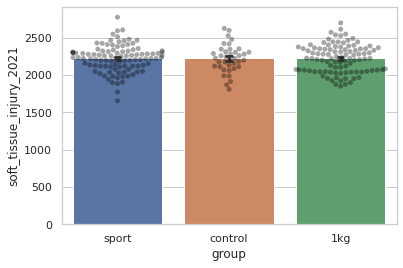

In [22]:
sns.set(style="whitegrid")

ax = sns.barplot(x='group', y='soft_tissue_injury_2021', data=results_to_plot, capsize=.05, ci=68)
ax = sns.swarmplot(x='group', y='soft_tissue_injury_2021', data=results_to_plot, color="0", alpha=.35)

#ax.set(ylim=(1500, 2800))

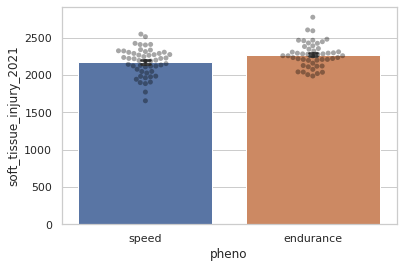

In [23]:
sns.set(style="whitegrid")

ax = sns.barplot(x='pheno', y='soft_tissue_injury_2021', data=results_to_plot, capsize=.05, ci=68)
ax = sns.swarmplot(x='pheno', y='soft_tissue_injury_2021', data=results_to_plot, color="0", alpha=.35)

#ax.set(ylim=(1500, 2500))


In [24]:
p_gts_sport = []

for t in t_test_gts_sport:
    p_gts_sport.append(t[1])
    
p_gts_kg = []

for t in t_test_gts_1kg:
    p_gts_kg.append(t[1])
    
p_kg_sport = []

for t in t_test_sport_1kg:
    p_kg_sport.append(t[1])
    
p_end_speed = []

for t in t_test_end_speed:
    p_end_speed.append(t[1])

list_results = pd.DataFrame([list(gene_lists), p_gts_sport, p_gts_kg, p_kg_sport, p_end_speed, 
                             gts_mean, gts_std, kg_mean, kg_std, sport_mean, sport_std, end_mean, end_std, speed_mean, speed_std])

In [25]:
list_results = list_results.transpose()

In [26]:
list_results.columns = ['gene_list', 'p_value_gts_sport', 'p_value_gts_1kg', 'p_value_1kg_sport', 'p_value_end_vs_speed', 'gts_mean', 'gts_std', 'kg_mean', 'kg_std', 'sport_mean', 'sport_std', 'end_mean', 'end_std',
                       'speed_mean', 'speed_std']

In [27]:
list_results.to_csv('sportsmen_burden_lists_results.csv')

In [33]:
list_results.iloc[32]

gene_list               expiratory_volume_best
p_value_gts_sport                     0.434787
p_value_gts_1kg                      0.0256357
p_value_1kg_sport                    0.0552249
p_value_end_vs_speed                  0.450853
gts_mean                               962.204
gts_std                                128.937
kg_mean                                1019.55
kg_std                                 133.153
sport_mean                             982.412
sport_std                              136.393
end_mean                               993.022
end_std                                143.299
speed_mean                             972.218
speed_std                               128.59
Name: 32, dtype: object

## continue with selected gene lists

In [32]:
gene_lists_dict['soft_tissue_injury_2021'].remove('BGN') #no variants in BGN

In [121]:
t_test_speed_gts = []
t_test_speed_1kg = []
t_test_end_speed = []
gts_mean = []
gts_std = []
kg_mean = []
kg_std = []
end_mean = []
end_std = []
speed_mean = []
speed_std = []

In [122]:
for g in gene_lists_dict['soft_tissue_injury_2021']:
    result = per_gene.filter_rows(per_gene.within_gene == g)
    print(result.count())
    print('the gene is:'+g)
    r = result['burden_cadd_phred'].collect()
    print()
    
    x = np.array(r)[np.array(phenotype) == 'speed']
    y = np.array(r)[np.array(groups) == 'control']
    t_test_speed_gts.append(stats.ttest_ind(x,y))
    
    x = np.array(r)[np.array(phenotype) == 'speed']
    y = np.array(r)[np.array(groups) == '1kg']
    t_test_speed_1kg.append(stats.ttest_ind(x,y))
    
    x = np.array(r)[np.array(phenotype) == 'endurance']
    y = np.array(r)[np.array(phenotype) == 'speed']
    t_test_end_speed.append(stats.ttest_ind(x,y))
    
    gts_mean.append(np.mean((np.array(r)[np.array(groups) == 'control'])))
    gts_std.append(np.std(np.array(r)[np.array(groups) == 'control']))
    
    kg_mean.append(np.mean((np.array(r)[np.array(groups) == '1kg'])))
    kg_std.append(np.std(np.array(r)[np.array(groups) == '1kg']))
    
    end_mean.append(np.mean((np.array(r)[np.array(phenotype) == 'endurance'])))
    end_std.append(np.std(np.array(r)[np.array(phenotype) == 'endurance']))
    
    speed_mean.append(np.mean((np.array(r)[np.array(phenotype) == 'speed'])))
    speed_std.append(np.std(np.array(r)[np.array(phenotype) == 'speed']))

np.save('results_list_array_per_gene', np.array(r))

res = np.load('results_list_array_per_gene.npy')

results_to_plot = pd.DataFrame(res).transpose()

results_to_plot['group'] = pd.Series(np.array(groups))
results_to_plot['phenotype'] = pd.Series(np.array(phenotype))

(1, 236)
the gene is:COL12A1

(1, 236)
the gene is:TIMP2

(1, 236)
the gene is:TNC

(1, 236)
the gene is:CASP8

(1, 236)
the gene is:IL1B

(1, 236)
the gene is:IL6

(1, 236)
the gene is:COL5A1

(1, 236)
the gene is:ACAN

(1, 236)
the gene is:VEGFA

(1, 236)
the gene is:ACTN3

(1, 236)
the gene is:COL1A1

(1, 236)
the gene is:MMP3

(1, 236)
the gene is:COL3A1

(1, 236)
the gene is:MMP1

(1, 236)
the gene is:KDR



In [123]:
p_speed_gts = []

for t in t_test_speed_gts:
    p_speed_gts.append(t[1])
    
p_speed_kg = []

for t in t_test_speed_1kg:
    p_speed_kg.append(t[1])

p_end_speed = []

for t in t_test_end_speed:
    p_end_speed.append(t[1])

list_results = pd.DataFrame([gene_lists_dict['soft_tissue_injury_2021'], p_speed_gts, p_speed_kg, p_end_speed, 
                             gts_mean, gts_std, kg_mean, kg_std, end_mean, end_std, speed_mean, speed_std])

list_results = list_results.transpose()

In [124]:
list_results.columns = ['gene', 'p_speed_gts', 'p_speed_1kg', 'p_end_speed', 
                             'gts_mean', 'gts_std', '1kg_mean', '1kg_std', 'end_mean', 'end_std', 'speed_mean', 'speed_std']


In [125]:
list_results

,gene,p_speed_gts,p_speed_1kg,p_end_speed,gts_mean,gts_std,1kg_mean,1kg_std,end_mean,end_std,speed_mean,speed_std
0,COL12A1,0.729259,0.453169,0.601167,235.694,51.9885,245.088,37.0324,244.558,42.9599,239.559,50.8777
1,TIMP2,0.190874,0.461495,0.563469,97.443,19.5428,99.9684,20.9368,100.591,15.9185,102.452,15.8664
2,TNC,0.0588554,0.0486508,0.549517,225.602,69.8864,224.455,83.0811,205.72,67.0789,197.692,65.2371
3,CASP8,0.899098,0.904087,0.12537,60.9927,20.085,61.9739,19.0875,67.4417,16.3641,61.5598,20.9277
4,IL1B,0.177843,0.221621,0.857339,15.12,5.63777,14.6193,6.3134,13.4658,6.43377,13.2208,6.99458
5,IL6,0.170895,0.0073131,0.569532,52.8269,38.6322,57.2048,31.1483,39.2502,32.1512,42.7875,29.1856
6,COL5A1,0.120911,0.138869,0.0157523,161.903,31.5243,140.807,38.136,166.7,29.7857,150.433,35.378
7,ACAN,0.35347,0.198846,0.288337,166.17,54.8515,165.16,53.0514,188.633,53.8418,177.08,53.2774
8,VEGFA,0.704141,0.0897578,0.05861,77.8358,22.1175,83.6537,27.3992,85.6118,27.2235,75.9975,22.3671
9,ACTN3,0.924354,0.878106,0.289455,80.6086,55.5295,80.4666,43.637,91.7244,40.6437,81.7086,51.5685


In [126]:
list_results.to_csv('soft_tissue_results_5.csv')

In [12]:
gene_lists_dict.keys()

dict_keys(['brain', 'sekletal_muscle', 'heart', 'Hp_0011804', 'Hp_0011805', 'endurance_markers_2021', 'power_markers_2021', 'strength_markers_2021', 'soft_tissue_injury_2021', 'Cerebral_Cortex', 'Basal_Ganglia', 'Hypothalmus', 'Thalmus', 'Midbrain', 'Dopaminergiczna', 'Serotoninergiczna', 'Noradrenergiczna', 'GABA', 'SLITRK', 'all_neurotransmitters', 'Gutaminian', 'Serotonina_Kannabinoidy', 'Dopamina_Acetylocholina', 'geny_GTS', 'Synapsy', 'Tryptofan', 'Ligand_receptor', 'calcium', 'androgenowy', 'addiction', 'cancer_diagnosed', 'cystic_kidney_disease', 'expiratory_volume_best', 'hand_grip_left', 'hand_grip_right'])

In [14]:
main_lists = [gene_lists_dict['sekletal_muscle'], gene_lists_dict['Midbrain'], gene_lists_dict['Noradrenergiczna']]

In [121]:
t_test_speed_gts = []
t_test_speed_1kg = []
t_test_end_speed = []
gts_mean = []
gts_std = []
kg_mean = []
kg_std = []
end_mean = []
end_std = []
speed_mean = []
speed_std = []

In [122]:
for g in gene_lists_dict['soft_tissue_injury_2021']:
    result = per_gene.filter_rows(per_gene.within_gene == g)
    print(result.count())
    print('the gene is:'+g)
    r = result['burden_cadd_phred'].collect()
    print()
    
    x = np.array(r)[np.array(phenotype) == 'speed']
    y = np.array(r)[np.array(groups) == 'control']
    t_test_speed_gts.append(stats.ttest_ind(x,y))
    
    x = np.array(r)[np.array(phenotype) == 'speed']
    y = np.array(r)[np.array(groups) == '1kg']
    t_test_speed_1kg.append(stats.ttest_ind(x,y))
    
    x = np.array(r)[np.array(phenotype) == 'endurance']
    y = np.array(r)[np.array(phenotype) == 'speed']
    t_test_end_speed.append(stats.ttest_ind(x,y))
    
    gts_mean.append(np.mean((np.array(r)[np.array(groups) == 'control'])))
    gts_std.append(np.std(np.array(r)[np.array(groups) == 'control']))
    
    kg_mean.append(np.mean((np.array(r)[np.array(groups) == '1kg'])))
    kg_std.append(np.std(np.array(r)[np.array(groups) == '1kg']))
    
    end_mean.append(np.mean((np.array(r)[np.array(phenotype) == 'endurance'])))
    end_std.append(np.std(np.array(r)[np.array(phenotype) == 'endurance']))
    
    speed_mean.append(np.mean((np.array(r)[np.array(phenotype) == 'speed'])))
    speed_std.append(np.std(np.array(r)[np.array(phenotype) == 'speed']))

np.save('results_list_array_per_gene', np.array(r))

res = np.load('results_list_array_per_gene.npy')

results_to_plot = pd.DataFrame(res).transpose()

results_to_plot['group'] = pd.Series(np.array(groups))
results_to_plot['phenotype'] = pd.Series(np.array(phenotype))

(1, 236)
the gene is:COL12A1

(1, 236)
the gene is:TIMP2

(1, 236)
the gene is:TNC

(1, 236)
the gene is:CASP8

(1, 236)
the gene is:IL1B

(1, 236)
the gene is:IL6

(1, 236)
the gene is:COL5A1

(1, 236)
the gene is:ACAN

(1, 236)
the gene is:VEGFA

(1, 236)
the gene is:ACTN3

(1, 236)
the gene is:COL1A1

(1, 236)
the gene is:MMP3

(1, 236)
the gene is:COL3A1

(1, 236)
the gene is:MMP1

(1, 236)
the gene is:KDR



In [123]:
p_speed_gts = []

for t in t_test_speed_gts:
    p_speed_gts.append(t[1])
    
p_speed_kg = []

for t in t_test_speed_1kg:
    p_speed_kg.append(t[1])

p_end_speed = []

for t in t_test_end_speed:
    p_end_speed.append(t[1])

list_results = pd.DataFrame([gene_lists_dict['soft_tissue_injury_2021'], p_speed_gts, p_speed_kg, p_end_speed, 
                             gts_mean, gts_std, kg_mean, kg_std, end_mean, end_std, speed_mean, speed_std])

list_results = list_results.transpose()

In [124]:
list_results.columns = ['gene', 'p_speed_gts', 'p_speed_1kg', 'p_end_speed', 
                             'gts_mean', 'gts_std', '1kg_mean', '1kg_std', 'end_mean', 'end_std', 'speed_mean', 'speed_std']


In [125]:
list_results

,gene,p_speed_gts,p_speed_1kg,p_end_speed,gts_mean,gts_std,1kg_mean,1kg_std,end_mean,end_std,speed_mean,speed_std
0,COL12A1,0.729259,0.453169,0.601167,235.694,51.9885,245.088,37.0324,244.558,42.9599,239.559,50.8777
1,TIMP2,0.190874,0.461495,0.563469,97.443,19.5428,99.9684,20.9368,100.591,15.9185,102.452,15.8664
2,TNC,0.0588554,0.0486508,0.549517,225.602,69.8864,224.455,83.0811,205.72,67.0789,197.692,65.2371
3,CASP8,0.899098,0.904087,0.12537,60.9927,20.085,61.9739,19.0875,67.4417,16.3641,61.5598,20.9277
4,IL1B,0.177843,0.221621,0.857339,15.12,5.63777,14.6193,6.3134,13.4658,6.43377,13.2208,6.99458
5,IL6,0.170895,0.0073131,0.569532,52.8269,38.6322,57.2048,31.1483,39.2502,32.1512,42.7875,29.1856
6,COL5A1,0.120911,0.138869,0.0157523,161.903,31.5243,140.807,38.136,166.7,29.7857,150.433,35.378
7,ACAN,0.35347,0.198846,0.288337,166.17,54.8515,165.16,53.0514,188.633,53.8418,177.08,53.2774
8,VEGFA,0.704141,0.0897578,0.05861,77.8358,22.1175,83.6537,27.3992,85.6118,27.2235,75.9975,22.3671
9,ACTN3,0.924354,0.878106,0.289455,80.6086,55.5295,80.4666,43.637,91.7244,40.6437,81.7086,51.5685


In [126]:
list_results.to_csv('soft_tissue_results_5.csv')